<div align="right">Python 2.7 Jupyter Notebook</div>

# Introduction to Funf

### Your completion of the notebook exercises will be graded based on your ability to: 

> **Apply**: Are you able to execute code, using the supplied examples, that perform the required functionality on supplied or generated data sets? 

> **Evaluate**: Are you able to interpret the results and justify your interpretation based on the observed data?

# Notebook introduction

Data from the following two publicly available datasets will be used:
1. [Friends and Family](http://realitycommons.media.mit.edu/friendsdataset.html) by MIT Media Lab, and 
2. [Student Life](http://studentlife.cs.dartmouth.edu/dataset.html) by Dartmouth college. 

The "Friends and Family" dataset was generated using Funf. The "Student Life" data set contains similar data and while not created using Funf, Funf is quoted as one of its main sources of inspiration. You can read more about the data sets in the provided links.

> **Note**:
>[Funf](https://github.com/OpenSensing/funf-core-android) was introduced to you in Video 4 of this module. You are welcome to review the code on GitHub, as well as download and create your own application. Should you wish to do so, it is a good idea to start [here](https://github.com/funf-org/funf-core-android/wiki/WifiScannerTutorial).

In the exercises that follow, you will familiarize yourself with some of the key features of the two datasets. The first exercise will focus on social features, namely: Call logs and SMS. In the second exercise you will visualize the mobility trace for a user over a week, as well as for the term.

There are many other features that can be explored in the datasets. Many of them are labeled as “technical”, as a certain degree of wrangling is required before they can be used to analyze networks of social interactions.


The features demonstrated and contained in the datasets do not form a comprehensive list of all the possible sensor datasets. Additional options include accelerometer data used by fitness trackers, “screen on" status, and many others. When analyzing populations you will most likely start with the basics. You will then expand on these basics with additional features where available, as well as where you have analyzed the additional datasets and found them to be useful in solving the particular problem that you are trying to solve.


> **Note**: 

> It is strongly recommended that you save a checkpoint after applying significant changes or completing exercises. This allows you to return the notebook to a previous state should you wish to do so. On the Jupyter menu, select "File", then "Save and Checkpoint" from the dropdown menu that appears.

#### Load libraries and set options
As usual, our Python toolbox consists of pandas and numpy. Folium is also added, as maps will be added to this notebook at a later stage.

In [29]:
import pandas as pd
import numpy as np
import folium
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)

Populating the interactive namespace from numpy and matplotlib


## 1. Friends and Family - Call logs and SMS
You will run sample scripts to examine the datasets and visualize the timelines of various sensor readings. 

### 1.1 Analyze the call log of a single user
The "Friends and Family" dataset contains all users' calls in one file. One participant, "fa10-01-08", has been chosen as an example.

### 1.1 Analyze CallLog

#### Data preparation

To start our analysis, we will:
- Load the dataset.
- Parse the datetime and sort the dataset by this column.
- Filter the dataset to review a single user.
- Examine the top rows in our new dataset.

In [30]:
# Load the dataset.
calls = pd.read_csv('../data/CallLog.csv')

# Parse datetimes using the Pandas function.
calls['local_time'] = pd.to_datetime(calls['local_time'])

# Index the dataset by the datetime column.
calls.set_index('local_time', inplace=True)

# Sort the dataset in place.
calls.sort_index(inplace=True)

# Set the user to be evaluated.
example_user = 'fa10-01-08'

# Create a subset of the data where participantID.A 
#     is the selected user using the copy method.
call_example = calls[calls['participantID.B'] == example_user].copy()

# Add a column where the week is derived from the datetime column.
call_example['week'] = call_example.index.map(lambda observation_timestamp: 
                                              observation_timestamp.week)

# Display the head of the new dataset.
call_example.head(3)


,participantID.A,participantID.B,type,duration,number.hash,week
local_time,,,,,,
2010-07-31 21:31:25,fa10-01-08,fa10-01-08,incoming+,NaN,84ae45baecadf7414ef18390f93c63c700b42e9,30
2010-08-06 09:22:55,fa10-01-08,fa10-01-08,incoming+,NaN,84ae45baecadf7414ef18390f93c63c700b42e9,31
2010-08-06 13:11:36,fa10-01-08,fa10-01-08,incoming+,NaN,84ae45baecadf7414ef18390f93c63c700b42e9,31


Review the unique types of records present in the dataset.

In [31]:
# Display the unique records for "type"
call_example.type.unique()

array(['incoming+', 'outgoing+', 'outgoing', 'incoming', 'missed'], dtype=object)

Next, the weekly bins for the records of the types that we are interested in will be created, and the weekly summary will be displayed. Missed calls have been excluded for the purpose of this exercise.

In [32]:
# Create a new variable, call_groups, containing call_example grouped by week.
call_groups = call_example.groupby(['week'], sort=False)

# Create a pandas dataframe.
call_weeks = pd.DataFrame(columns=['week', 'outgoing', 'incoming', 'total'])  

# Set the index for the new dataframe.
call_weeks.set_index('week', inplace=True)

# Next we create a summary table based on the observed types.
for week, group in call_groups:
    inc = 0
    out = 0
    
    try:
        inc += pd.value_counts(group.type)['incoming+']
    except KeyError:
        pass
    
    try:
        inc += pd.value_counts(group.type)['incoming']
    except KeyError:
        pass
    
    try:    
        out += pd.value_counts(group.type)['outgoing+']
    except KeyError:
        pass
    
    try:    
        out += pd.value_counts(group.type)['outgoing']
    except KeyError:
        pass
    
    call_weeks.loc[week] = [out, inc, out+inc]

# Display the head of our new dataset.
call_weeks.head(3)

,outgoing,incoming,total
week,,,
30,0.0,1.0,1.0
31,1.0,12.0,13.0
32,2.0,1.0,3.0


The calls per week can now be visualized using a barplot.

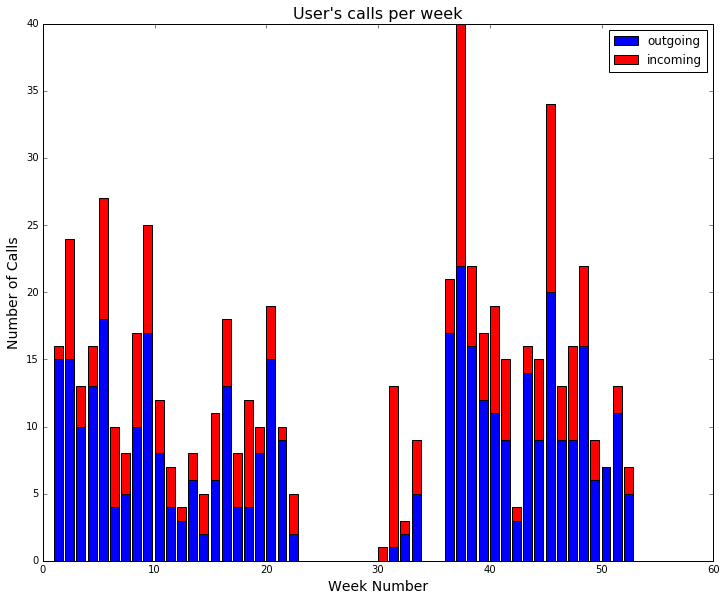

In [33]:
# Set plotting options
fig, ax = plt.subplots()
tight_layout()

# Add outgoing calls to our plot
plt.bar(call_weeks.reset_index()['week'], call_weeks['outgoing'], 
        color='b', label='outgoing')

# Add incoming calls to our plot
plt.bar(call_weeks.reset_index()['week'], call_weeks['incoming'], 
        color='r', bottom=call_weeks['outgoing'], label='incoming')

# Plot formatting options
ax.set_xlabel("Week Number", fontsize=14)
ax.set_ylabel("Number of Calls", fontsize=14)
ax.set_title("User's calls per week", fontsize=16)
plt.legend()

### 1.2 Analyze SMS

The exercise in the previous section will now be repeated with the SMS records for the same user.

In [34]:
# Load the dataset.
sms = pd.read_csv('../data/SMSLog.csv')

# Parse datetimes using the Pandas function.
sms['local_time'] = pd.to_datetime(sms['local_time'] )

# Index the dataset by the datetime column.
sms.set_index('local_time', inplace=True)

# Sort the dataset in place.
sms.sort_index(inplace=True)

# We have set the user to be evaluated in the call logs section and will 
#     reference the variable here. Create a subset of the data where 
#     participantID.A is the selected user using the copy method.
sms_example = sms[sms['participantID.B'] == example_user].copy()

# Add a column where the week is derived from the datetime column.
sms_example['week'] = sms_example.index.map(lambda observation_timestamp: 
                                            observation_timestamp.week)

# Display the head of the new dataset.
sms_example.head(3)

,participantID.A,participantID.B,type,number.hash,week
local_time,,,,,
2010-08-20 17:34:22,fa10-01-08,fa10-01-08,outgoing,84ae45baecadf7414ef18390f93c63c700b42e9,33
2010-09-09 14:52:18,fa10-01-07,fa10-01-08,incoming,fa12ad90214a28ae00cd96d57c9151a1dff8a574,36
2010-09-11 11:36:24,fa10-01-07,fa10-01-08,incoming,fa12ad90214a28ae00cd96d57c9151a1dff8a574,36


Review the unique types of records present in the dataset.

In [35]:
sms_example.type.unique()

array(['outgoing', 'incoming'], dtype=object)

Next, the weekly bins for the records of the types that we are interested in are created again (as was done in the previous section), and the weekly summary will be displayed.

In [36]:
# Create a new variable, sms_groups, containing call_example grouped by week.
sms_groups = sms_example.groupby(['week'], sort=False)

# Create a pandas dataframe.
sms_weeks = pd.DataFrame(columns=['week', 'outgoing', 'incoming', 'total'])  

# Set the index for the new dataframe.
sms_weeks.set_index('week', inplace=True)

# Next we create a summary table based on the observed types.
for week, group in sms_groups:
    try:
        inc = pd.value_counts(group.type)['incoming']
    except KeyError:
        inc = 0
        
    try:    
        out = pd.value_counts(group.type)['outgoing']
    except KeyError:
        out = 0
    sms_weeks.loc[week] = [out, inc, out+inc]

# Display the head of our new dataset.
sms_weeks.head(3)

,outgoing,incoming,total
week,,,
33,1.0,0.0,1.0
36,3.0,5.0,8.0
37,3.0,7.0,10.0


The SMSs per week can now be visualized using a barplot.

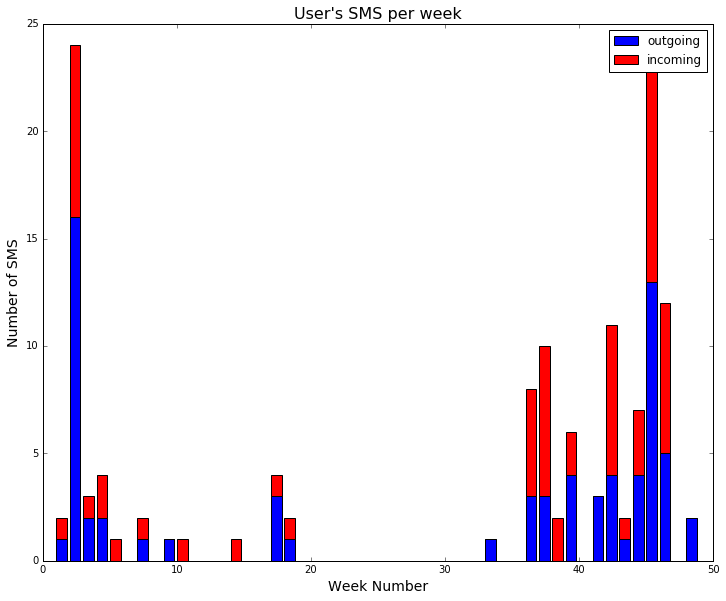

In [37]:
# Set plotting options
fig, ax = plt.subplots()
tight_layout()

# Add outgoing sms to our plot
plt.bar(sms_weeks.reset_index()['week'], sms_weeks['outgoing'], 
        color='b', label='outgoing')

# Add incoming sms to our plot
plt.bar(sms_weeks.reset_index()['week'], sms_weeks['incoming'], 
        color='r', bottom=sms_weeks['outgoing'], label='incoming')

# Plot formatting options
ax.set_xlabel("Week Number", fontsize=14)
ax.set_ylabel("Number of SMS", fontsize=14)
ax.set_title("User's SMS per week", fontsize=16)
plt.legend()

> **Note**:

> You can select other users and re-execute the cells above for both call and sms logs to test your intuition about the differences in behaviour of students should you wish to do so. This activity will not be graded


# 2. Dartmouth - Location history example
You will run sample scripts to examine the dataset and visualize the timeline of the location data. The Dartmouth dataset has been selected for this example because the locations in the "Friends and Family" dataset are encrypted and not suitable for use in this visual exercise.

### 2.1 Analyze the location of a single user
The "Student Life" dataset contains separate files for each of the users. User 31 has been selected for this example.

Data preparation will need to be completed before our analysis can start. The following tasks will need to be carried out: load the dataset, parse the datetime, and sort it by this column. The dataset will then need to be filtered to review a single user. 

In [67]:
# Import the dataset and display the head.
loc = pd.read_csv('../data/dartmouth/location/gps_u31.csv')
loc.head(5)

,time,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate
0,1364407095,network,wifi,22.995,43.706616,-72.287025,0.000000,0.0,0.0,NaN
1,1364408295,network,wifi,22.667,43.706599,-72.287036,0.000000,0.0,0.0,NaN
2,1364411158,network,wifi,20.000,43.706584,-72.287006,0.000000,0.0,0.0,NaN
3,1364416681,network,wifi,22.421,43.706594,-72.287041,0.000000,0.0,0.0,NaN
4,1364417891,gps,NaN,11.000,43.702612,-72.289307,131.399994,162.1,2.5,NaN


In the output above, the GPS coordinates are visible, and the dataset is very similar in structure to the "Friends and Family" dataset. In order to be able to work with this data as a chronological location trace, it needs to be indexed with sorted timestamps (in human-readable ISO format). The next step is to review the summary statistics of the re-indexed dataframe.

In [68]:
# Parse the dates.
loc['time'] = pd.to_datetime(loc['time'], unit='s')

# Set and reindex.
loc.set_index('time', inplace=True)
loc.sort_index(inplace=True)

# Display the head.
loc.head(3)

,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate
time,,,,,,,,,
2013-03-27 17:58:15,network,wifi,22.995,43.706616,-72.287025,0.0,0.0,0.0,NaN
2013-03-27 18:18:15,network,wifi,22.667,43.706599,-72.287036,0.0,0.0,0.0,NaN
2013-03-27 19:05:58,network,wifi,20.000,43.706584,-72.287006,0.0,0.0,0.0,NaN


In [69]:
# Retrieve the start and end dates for the dataset and print the output.
start = pd.to_datetime(loc.index, unit='s').min()
end   = pd.to_datetime(loc.index, unit='s').max()
print ("Data covers {} between {} and {}".format(end - start, start, end))

# Calculate the median interval between observations and print the output.
median_interval = pd.Series(pd.to_datetime(loc.index, 
                                               unit='s')).diff().median().seconds / 60
print ("It has {} datapoints sampled with median interval of {} minutes."
       .format(len(loc), median_interval))

Data covers 63 days 17:08:07 between 2013-03-27 17:58:15 and 2013-05-30 11:06:22
It has 4203 datapoints sampled with median interval of 20 minutes.


Next, the step to add a column with the week will be repeated, and the dataframe will be grouped by this column.

In [144]:
# Add a column containing the week.
loc['week'] = loc.index.map(lambda observation_timestamp: 
                            observation_timestamp.week)
loc.head(3)

,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,week
time,,,,,,,,,,
2013-03-27 17:58:15,network,wifi,22.995,43.706616,-72.287025,0.0,0.0,0.0,NaN,13
2013-03-27 18:18:15,network,wifi,22.667,43.706599,-72.287036,0.0,0.0,0.0,NaN,13
2013-03-27 19:05:58,network,wifi,20.000,43.706584,-72.287006,0.0,0.0,0.0,NaN,13


In [145]:
week15=loc[loc['week']==15]

Step1week15=week15[week15['travelstate']=='stationary']
Step1week15

,provider,network_type,accuracy,latitude,longitude,altitude,bearing,speed,travelstate,week
time,,,,,,,,,,
2013-04-08 00:03:35,network,wifi,35.006,43.706647,-72.286855,0.0,0.0,0.0,stationary,15
2013-04-08 00:23:35,network,wifi,22.621,43.706763,-72.286983,0.0,0.0,0.0,stationary,15
2013-04-08 00:43:35,network,wifi,23.551,43.706727,-72.287006,0.0,0.0,0.0,stationary,15
2013-04-08 01:03:35,network,wifi,21.766,43.706781,-72.286969,0.0,0.0,0.0,stationary,15
2013-04-08 01:23:27,network,wifi,22.030,43.706742,-72.286994,0.0,0.0,0.0,stationary,15
2013-04-08 01:43:35,network,wifi,25.580,43.706707,-72.287023,0.0,0.0,0.0,stationary,15
2013-04-08 02:02:40,network,wifi,24.028,43.706726,-72.287031,0.0,0.0,0.0,stationary,15
2013-04-08 02:23:35,network,wifi,29.165,43.706715,-72.287008,0.0,0.0,0.0,stationary,15
2013-04-08 02:43:35,network,wifi,29.309,43.706662,-72.286884,0.0,0.0,0.0,stationary,15


In [147]:
table = pd.DataFrame(Step1week15)
 
writer = pd.ExcelWriter('Step1week15.xlsx')
table.to_excel(writer, 'Step1week15')
writer.save()

Review the number of observations per week by grouping the data by the column added in the previous cell.

In [71]:
# Group by week and review the output.
week_gr = loc.groupby('week', axis=0)
pd.DataFrame(week_gr.size(), columns=['# of observations'])

,# of observations
week,
13,300
14,503
15,500
16,504
17,504
18,500
19,492
20,474
21,420


Next, the data will be plotted on a map. Some additional steps to prepare the data are required before this can be done. 

The coordinates from the location dataframe need to be extracted into a simpler format, one without indexes, column names, and unnecessary columns. This example will work on the weekly groupings and use dataframe df.as_matrix() methods, which return a raw numpy matrix.

In [72]:
weekly_travels = {}

for week, points in week_gr:
    weekly_travels[week] = points[['latitude', 'longitude']].as_matrix() 

> **Note**: 

> The Python visualization library, Folium, was introduced in an earlier notebook, but it is good to know that the center location and starting zoom level are options that you will need to set. In many cases your analysis will be centered around a known coordinate, in which case you can manually update the location. In other cases you will need to calculate the position based on your available data.

Now you can plot the data. The following example looks at a specific week.

In [73]:
# Set the center of the map and the zoom level. 
map_week15 = folium.Map(location=[43.706607,-72.287041], zoom_start=11)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[15], color='blue', weight=3, 
                opacity=0.5).add_to(map_week15)
map_week15

<br>
<div class="alert alert-info">
<b>Exercise 1 Start.</b>
</div>

### Instructions
> Copy the code in the previous cell and change week 15 to week 20 to produce the mobility trace for week 20. You need to replace "map_week15" with "map_week20" and retrieve element 20 from "weekly_travels[]".

> Additional option: Should you wish to do so, you can attempt to recenter the map and specify a different zoom level to produce a map that is better suited to the visualization. (The answer is demonstrated in the mobility trace for all data for the user further down in this notebook)

In [127]:
# Set the center of the map and the zoom level. 
map_week20 = folium.Map(location=[43.706607,-72.28704], zoom_start=9)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[20], color='blue', weight=3, 
                opacity=0.5).add_to(map_week20)
map_week20

<br>
<div class="alert alert-info">
<b>Exercise 1 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

<br>
<div class="alert alert-info">
<b>Exercise 2 Start.</b>
</div>

### Instructions
> When comparing the visual representation of the two weeks, you will see that the patterns are very similar. Please provide your high-level summary of the person's mobility in the cell below.

> Here are some questions to guide your answer:
- How many places do you think the person visited during week 15?
- Look at a couple of other weeks and indicate whether you think this person's behavior is predictable.
- Do you think this is a representative of general behavior, or do you think the number of places visited is lower or higher than you expected?

In [128]:
# Set the center of the map and the zoom level. 
map_week13 = folium.Map(location=[43.706607,-72.28704], zoom_start=9)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[13], color='blue', weight=3, 
                opacity=0.5).add_to(map_week13)
map_week13

In [129]:
# Set the center of the map and the zoom level. 
map_week14 = folium.Map(location=[43.706607,-72.28704], zoom_start=9)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[14], color='blue', weight=3, 
                opacity=0.5).add_to(map_week14)
map_week14

In [130]:
# Set the center of the map and the zoom level. 
map_week15 = folium.Map(location=[43.706607,-72.28704], zoom_start=9)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[15], color='blue', weight=3, 
                opacity=0.5).add_to(map_week15)
map_week15

In [131]:
# Set the center of the map and the zoom level. 
map_week16 = folium.Map(location=[43.706607,-72.28704], zoom_start=9)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[16], color='blue', weight=3, 
                opacity=0.5).add_to(map_week16)
map_week16

In [132]:
# Set the center of the map and the zoom level. 
map_week17 = folium.Map(location=[43.706607,-72.28704], zoom_start=9)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[17], color='blue', weight=3, 
                opacity=0.5).add_to(map_week17)
map_week17

In [133]:
# Set the center of the map and the zoom level. 
map_week18 = folium.Map(location=[43.706607,-72.28704], zoom_start=9)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[18], color='blue', weight=3, 
                opacity=0.5).add_to(map_week18)
map_week18

In [134]:
# Set the center of the map and the zoom level. 
map_week19 = folium.Map(location=[43.706607,-72.28704], zoom_start=9)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[19], color='blue', weight=3, 
                opacity=0.5).add_to(map_week19)
map_week19

In [135]:
# Set the center of the map and the zoom level. 
map_week20 = folium.Map(location=[43.706607,-72.28704], zoom_start=9)
# Plot the locations of observations.
folium.PolyLine(weekly_travels[20], color='blue', weight=3, 
                opacity=0.5).add_to(map_week20)
map_week20

In [136]:
map_week21 = folium.Map(location=[43.706607,-72.28704], zoom_start=9)
folium.PolyLine(weekly_travels[21], color='blue', weight=3, 
                opacity=0.5).add_to(map_week21)
map_week21

In [137]:
map_week22 = folium.Map(location=[43.706607,-72.28704], zoom_start=9)
folium.PolyLine(weekly_travels[22], color='blue', weight=3, 
                opacity=0.5).add_to(map_week22)
map_week22

A. How many places do you think the person visited during week 15?

I would say around 33-35 just counting end of routes or sharp turns. But counting the travelstate "stationary" where the user does not move more than let's say 50m by using his lattitude and longitude spreads would give a better idea of this count than trying to visually identify end of the road or concentrated zigzagging in localized areas.

B. Look at a couple of other weeks and indicate whether you think this person's behavior is predictable.

His behavior seems to be someway predictable. I would say he works or study in Hanover, NH, at Dartmouth College, in a building titled "Class of 1978 Life Service Center" and lives in East Wilder, on Indian Ridge Drive. And a about two times a month, he visits for work/research, family reasons, to visit friends or for weekend gateways Concord, Auburndale, Harvard or Brookline (Chestnut St). A trip in Guilford seems to be an outlier. But more weekly mappings could show more patterns. This dataset does not have enough observations to verify some of those patterns (Concord, Gilford, Auburndale and Harvard trips for example).

C. Do you think this is a representative of general behavior, or do you think the number of places visited is lower or higher than you expected?

I would instinctively say that he is visiting more places than average but does not travel more than avarage if we consider an average of 30 miles a day. Yes, his/her working and living places are just 1.5 miles appart but he travels several times a month to Boston, about 130 miles away from his usual work/life place in East Wilder and Hanover, NH.  

A recent study of the AAA Foundation (http://newsroom.aaa.com/2015/04/new-study-reveals-much-motorists-drive/) shows the following findings:

- Motorists age 16 years and older drive, on average, 29.2 miles per day or 10,658 miles per year.
- Women take more driving trips, but men spend 25 percent more time behind the wheel and drive 35 percent more miles than women.
- Both teenagers and seniors over the age of 75 drive less than any other age group; motorists 30-49 years old drive an average 13,140 miles annually, more than any other age group.
- The average distance and time spent driving increase in relation to higher levels of education. A driver with a grade school or some high school education drove an average of 19.9 miles and 32 minutes daily, while a college graduate drove an average of 37.2 miles and 58 minutes.
- Drivers who reported living “in the country” or “a small town” drive greater distances (12,264 miles annually) and spend a greater amount of time driving than people who described living in a “medium sized town” or city (9,709 miles annually).
- Motorists in the South drive the most (11,826 miles annually), while those in the Northeast drive the least (8,468 miles annually).
- On average, Americans drive fewer miles on the weekend than on weekdays.
- Americans drive, on average, the least during winter months (January through March) at 25.7 miles daily; they drive the most during the summer months (July through September) at 30.6 miles daily.

<br>
<div class="alert alert-info">
<b>Exercise 2 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

**Let's look at the mobility trace for all of the data for this user.**

In [113]:
# Retrieve all locations
all_points = loc[['latitude', 'longitude']].as_matrix()

map_alltime = folium.Map(location=[42.9297,-71.4352], zoom_start=8)
folium.PolyLine(all_points ,color='blue', weight=2, 
                opacity=0.5).add_to(map_week15).add_to(map_alltime)
map_alltime

<br>
<div class="alert alert-info">
<b>Exercise 3 Start.</b>
</div>

### Instructions

> What conclusions can you derive when comparing the person's mobility from the single weeks to the full dataset? Please provide your high-level summary in the cell below.

In comparison of weeks 15 and 20, the full dataset is even more consistent than vizually we do not see the weeks where the mobility of the user was limited to Hanover and East Wilder, supposedly his working and living places. Besides, we could note that the trip in Gilford, occured only in one instance in the dataset, could be an outlier.

<br>
<div class="alert alert-info">
<b>Exercise 3 End.</b>
</div>

> **Exercise complete**:
    
> This is a good time to "Save and Checkpoint".

## References
1. SocialfMRI: Investigating and shaping social mechanisms in the real world, Nadav Aharony, Wei Pan, Cory Ip,Inas Khayal, Alex Pentland, Pervasive and Mobile Computing, Volume 7, Issue 6, December 2011, Pages 643-659

2. Wang at al. *StudentLife: Assessing Mental Health, Academic Performance and Behavioral Trends of College Students 
    using Smartphones* In Proceedings of the ACM Conference on Ubiquitous Computing. 2014.

## 3. Submit your notebook

Please make sure that you:
- Perform a final "Save and Checkpoint";
- Download a copy of the notebook in ".ipynb" format to your local machine using "File", "Download as", and "IPython Notebook (.ipynb)"; and
- Submit a copy of this file to the online campus.